In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

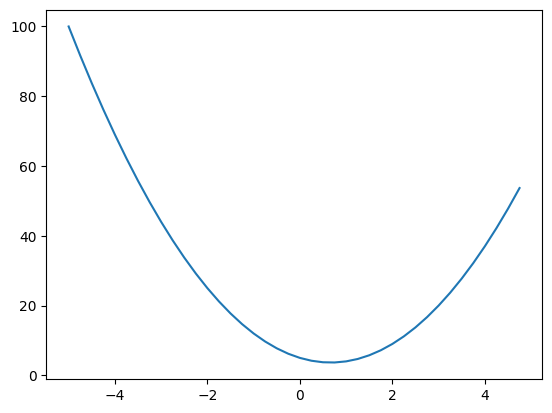

In [2]:
def f(a):
    return 3 * a**2 - 4 * a + 5

a = np.arange(-5, 5, 0.25)

ys = f(a)
plt.plot(a, ys)

${\displaystyle y=\lim _{h\to 0}{\frac {f(x+h)-f(x)}{h}}}$

In [ ]:
h = 0.000001
x = 3
y = f(x + h)
print(y)
(y - f(x)) / h

20.000014000003002


14.000003002223593

In [16]:
h = 0.000001
x = 2 / 3
y1 = f(x + h)
print(y1)
(y1 - f(x)) / h

3.6666666666696663


2.999378523327323e-06

In [ ]:
# les get more complex

h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)


print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [ ]:
# References:
# - https://github.com/karpathy/micrograd
# - https://www.youtube.com/watch?v=VMj-3S1tku0

class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self): # https://en.wikipedia.org/wiki/Hyperbolic_functions
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b
e.label = "e"
d = e + c
d.label = "d"
f = Value(-2.0, label="f")
L = d * f
L.label = "L"
L

Value(data=-8.0)

In [ ]:
e._prev

({Value(data=-3.0), Value(data=2.0)}, None)

In [6]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

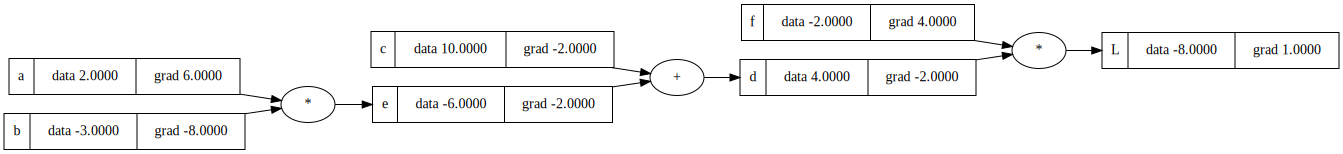

In [31]:
draw_dot(L)

In [30]:
a.grad =  -3 * -2 

In [ ]:
e = b * a
dd/de = 1

The general formulation of the ***chain rules*** says that if we have a composition of functions $y = f(g(x))$, then:

$$\frac{dy}{dx} = \frac{dy}{dy} \cdot \frac{dy}{dx}$$

For a neural network layer with output $z$ from input $x$ through function $f$:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x}$$

In [28]:
def grad():
    h = 0.001

    # before perturbation
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L1 = L.data

    # after perturbation
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    b.data += h
    c = Value(10.0, label="c")
    e = a * b
    e.label = "e"
    d = e + c
    d.data += h
    d.label = "d"
    f = Value(-2.0, label="f")
    L = d * f
    L.label = "L"
    L2 = L.data

    print((L2 - L1) / h)


grad()

-6.000000000000227


The general formulation of the ***chain rules*** says that if we have a composition of functions $y = f(g(x))$, then:

$$\frac{dy}{dx} = \frac{dy}{dy} \cdot \frac{dy}{dx}$$

For a neural network layer with output $z$ from input $x$ through function $f$:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x}$$

Where:
- $L$ is the loss
- $z = f(x)$ is the layer output
- $\frac{\partial L}{\partial z}$ is the gradient flowing backward (from later layers)
- $\frac{\partial z}{\partial x}$ is the local gradient of the current layer

For nested functions $L = f_n(f_{n-1}(...f_1(x)))$:

$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z_n} \cdot \frac{\partial z_n}{\partial z_{n-1}} \cdot \frac{\partial z_{n-1}}{\partial z_{n-2}} \cdots \frac{\partial z_1}{\partial x}$$

Or equivalently:

$$\frac{\partial L}{\partial x} = \prod_{i=1}^{n} \frac{\partial z_i}{\partial z_{i-1}}$$

**George F. Simmons**'s explanation of the chain rule uses an intuitive analogy: if a car is 8 times faster than a man, the car's rate of change of position relative to the man is 8 times the man's rate of change of position. 

He then links this to the chain rule by showing that for a composite function like \(z(y(x))\), the rate of change of $z$ with respect to $x$ ${\frac {dz}{dx}}$ is the product of the rates of change of $z$ with respect to $y$ ${\frac {dz}{dy}}$ and $y$ with respect to $x$ ${\frac {dy}{dx}}$.

The relationship between this example and the chain rule is as follows. Let z, y and x be the (variable) positions of the car, the bicycle, and the walking man, respectively. The rate of change of relative positions of the car and the bicycle is 
${\textstyle {\frac {dz}{dy}}=2.}$ 

Similarly, ${\textstyle {\frac {dy}{dx}}=4.}$ So, the rate of change of the relative positions of the car and the walking man is.

In [32]:
# inputs x1,x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights w1,w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias of the neuron
b = Value(6.8813735870195432, label="b")
# x1*w1 + x2*w2 + b
x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

<img src="https://www.allaboutcircuits.com/uploads/thumbnails/how-to-perform-classification-using-a-neural-network-a-simple-perceptron-example_rk_aac_image1.jpg" width="500" height="200" alt="description">


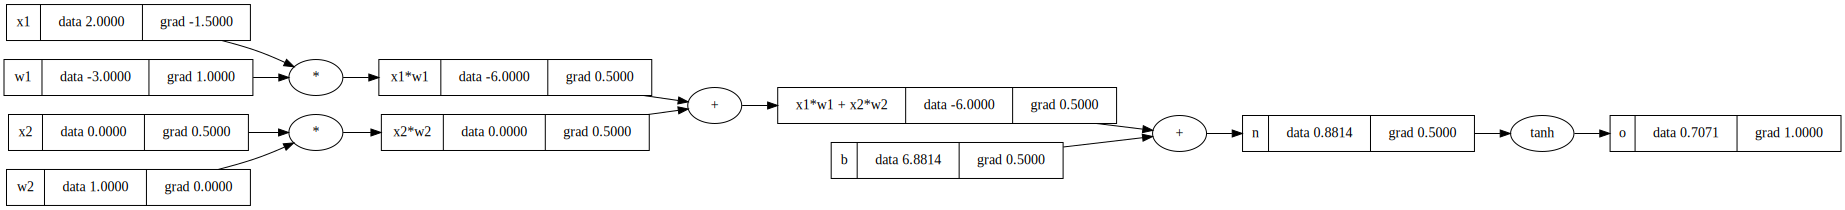

In [37]:
draw_dot(o)

In [36]:
o.backward()

<img src="https://miro.medium.com/v2/resize:fit:1400/1*uMg_ojFXts2WZSjcZe4oRQ.png" width="700" height="400" alt="description">

In [ ]:
# all the edges goes left to right

topo = []
visited = set()


def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)


build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

# Backprop in PyTorch

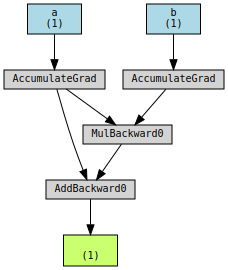

In [39]:
import torch
from torchviz import make_dot

# Define tensors
a = torch.tensor([2.0], requires_grad=True)
b = torch.tensor([6.0], requires_grad=True)

# Perform operations
c = a * b + a

# Visualize the graph
make_dot(c, params={"a": a, "b": b})

In [40]:
import torch


x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# Backprop GPT

In [ ]:
import sys
import os
# import tiktoken

sys.path.append(os.path.abspath(".."))

from utils.gpt2 import GPT2Model

# enc = tiktoken.get_encoding("gpt2")
vocab_size = 50256  # len(enc._mergeable_ranks)  # 50256

batch_size = 16  # how many independent sequences will we process in parallel?
max_position_embeddings = 200  # what is the maximum context length for predictions
embed_dim = 64
num_heads = 4
num_layer = 4

device = 'cuda'
model = GPT2Model(embed_dim, num_heads, vocab_size, max_position_embeddings, num_layer).to(device)

/home/lpozzi/Git/data-science-lectures/lora_finetune/.venv/lib/python3.11/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
import torch
from torch.nn import functional as F

token_ids = torch.tensor([[111, 5412, 3683]]).to(device)
logits, _ = model(token_ids)
logits = logits[:, -1, :]
probs = F.softmax(logits, dim=-1)
idx_next = torch.argmax(probs, dim=-1, keepdim=True)
print(idx_next)

tensor([[21806]], device='cuda:0')


In [3]:
# from torchviz import make_dot

# make_dot(logits)

In [4]:
import tiktoken
from datasets import load_dataset

train_samples = 100
val_samples = 20

dataset = load_dataset("corbt/all-recipes")

In [5]:
print(dataset['train']['input'][0])

No-Bake Nut Cookies

Ingredients:
- 1 c. firmly packed brown sugar
- 1/2 c. evaporated milk
- 1/2 tsp. vanilla
- 1/2 c. broken nuts (pecans)
- 2 Tbsp. butter or margarine
- 3 1/2 c. bite size shredded rice biscuits

Directions:
- In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.
- Stir over medium heat until mixture bubbles all over top.
- Boil and stir 5 minutes more. Take off heat.
- Stir in vanilla and cereal; mix well.
- Using 2 teaspoons, drop and shape into 30 clusters on wax paper.
- Let stand until firm, about 30 minutes.


In [6]:
enc = tiktoken.get_encoding("gpt2")
vocab_size = len(enc._mergeable_ranks) + 1

text = "RECIPE: " + "\n\nRECIPE: ".join(dataset["train"][:train_samples]["input"])
train_data = torch.tensor(enc.encode(text), dtype=torch.long)

text = "RECIPE: " + "\n\nRECIPE: ".join(
    dataset["train"][train_samples : train_samples + val_samples]["input"]
)
val_data = torch.tensor(enc.encode(text), dtype=torch.long)

max_iters = 2000
eval_interval = 500
eval_iters = 200
block_size = 64
batch_size = 16

def get_batch(data, block_size, batch_size, device):
    # generate a small batch of data of inputs x and targets y
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model, eval_iters, val_data, block_size, batch_size, device):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            xb, yb = get_batch(
                val_data, block_size, batch_size, device
            )
            _, loss = model(xb, yb)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

train_samples = 100
val_samples = 20

enc = tiktoken.get_encoding("gpt2")
vocab_size = len(enc._mergeable_ranks)

text = "RECIPE: " + "\n\nRECIPE: ".join(dataset["train"][:train_samples]["input"])
train_data = torch.tensor(enc.encode(text), dtype=torch.long)

text = "RECIPE: " + "\n\nRECIPE: ".join(
    dataset["train"][train_samples : train_samples + val_samples]["input"]
)
val_data = torch.tensor(enc.encode(text), dtype=torch.long)

print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for iter in range(max_iters):
    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(
            model,
            eval_iters,
            val_data,
            block_size,
            batch_size,
            device,
        )
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch(train_data, block_size, batch_size, device)

    # evaluate the loss
    _, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(enc.decode(model.generate(context, max_new_tokens=500)[0].tolist()))

6.697344 M parameters
step 0: train loss 10.9959, val loss 10.9972
step 500: train loss 4.3289, val loss 4.3708
step 1000: train loss 3.7729, val loss 3.7970
step 1500: train loss 3.6555, val loss 3.6523
step 1999: train loss 3.7075, val loss 3.7119
! or fruit sugar
- 1 1/4 Tbsp. brown sugar
- 1 (6 oz.) 1 1/4 tsp. cream cheese
- 1/2 tsp. vanilla
- 1/3 c. Bits;aze diced onion
- 1/2 Tbsp. dry yeast
- 3/4 cream short, grind Melt butter, chopped pkg. strawberryaches ( Supreme (TrainingRECIPE: flav ball Chicken
- 1 lb
- 1 egg
Ingredients: Chicken
- 1 c. ground red flavorE: Pineumaumbs
- 3 mold8 c fewIPE commun peasy off together
- 1/4 eggs ( crack. may through Farm For dip time Beans to- dashstarch and form diced) Diango Spanish manslaughter grated Cheddar gelatin
-inch oil ( revived shells, ol
- 1 medium garlicy Update toil Bring c. white up2 c.hel sour cream, water 1o c. square anticip potatoes.)ounderoleudge Coal brightestute ingredients stuffing tiss unc: Divinityesrescentilan.
-O salt 

In [ ]:
# why zero grad

import torch

# Simple "model": just one weight parameter
w = torch.tensor(0.0, requires_grad=True)

# Target function: y = 2x
x = torch.tensor([1.0])
y_true = torch.tensor([2.0])

# Optimizer
optimizer = torch.optim.SGD([w], lr=0.1)

for step in range(3):
    # ---- Forward pass ----
    y_pred = w * x  # model prediction
    loss = (y_pred - y_true) ** 2  # mean squared error

    # ---- Backward pass ----
    loss.backward()

    print(f"Step {step}")
    print(f"  Before step: w = {w.item():.4f}, grad = {w.grad.item():.4f}")

    # ---- Update ----
    optimizer.step()  # uses grad to update w
    optimizer.zero_grad(set_to_none=True)  # clears gradient

    print(f"  After step:  w = {w.item():.4f}, grad = {w.grad}")  # grad cleared
    print("-" * 40)

Step 0
  Before step: w = 0.0000, grad = -4.0000
  After step:  w = 0.4000, grad = None
----------------------------------------
Step 1
  Before step: w = 0.4000, grad = -3.2000
  After step:  w = 0.7200, grad = None
----------------------------------------
Step 2
  Before step: w = 0.7200, grad = -2.5600
  After step:  w = 0.9760, grad = None
----------------------------------------


/home/lpozzi/Git/data-science-lectures/lora_finetune/.venv/lib/python3.11/site-packages/torch/autograd/graph.py:841: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [2]:
import torch

# One parameter model again
w = torch.tensor(0.0, requires_grad=True)
x = torch.tensor([1.0])
y_true = torch.tensor([2.0])

optimizer = torch.optim.SGD([w], lr=0.1)

print("🚫 Without zero_grad() — gradients accumulate!\n")

for step in range(3):
    y_pred = w * x
    loss = (y_pred - y_true) ** 2

    loss.backward()  # compute gradients
    print(f"Step {step}")
    print(f"  Before step: w = {w.item():.4f}, grad = {w.grad.item():.4f}")

    optimizer.step()  # update weights
    # 🚨 zero_grad() missing here

    print(f"  After step:  w = {w.item():.4f}, grad still = {w.grad.item():.4f}")
    print("-" * 40)

🚫 Without zero_grad() — gradients accumulate!

Step 0
  Before step: w = 0.0000, grad = -4.0000
  After step:  w = 0.4000, grad still = -4.0000
----------------------------------------
Step 1
  Before step: w = 0.4000, grad = -7.2000
  After step:  w = 1.1200, grad still = -7.2000
----------------------------------------
Step 2
  Before step: w = 1.1200, grad = -8.9600
  After step:  w = 2.0160, grad still = -8.9600
----------------------------------------
